In [60]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
from google.colab.patches import cv2

In [61]:
! git clone https://github.com/srohit0/food_mnist.git

import food_mnist


fatal: destination path 'food_mnist' already exists and is not an empty directory.


In [62]:
os.listdir('food_mnist/images')

['bibimbap',
 'baby_back_ribs',
 'food-collage.jpg',
 'beef_tartare',
 'beignets',
 'beet_salad',
 'breakfast_burrito',
 'bread_pudding',
 'apple_pie',
 'baklava',
 'beef_carpaccio']

In [ ]:
os.listdir('food_mnist/meta')

['test.txt', 'classes.txt', 'test.json', 'train.txt', 'train.json']

In [ ]:
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
print("Creating train data...")
prepare_data('food_mnist/meta/train.txt', 'food_mnist/images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito
Copying Done!


In [ ]:
print("Creating test data...")
prepare_data('food_mnist/meta/test.txt', 'food_mnist/images', 'test')


Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito
Copying Done!


In [ ]:
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
food_list = ['apple_pie','baby_back_ribs','baklava', 'beef_carpaccio']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into baby_back_ribs
Copying images into baklava
Copying images into beef_carpaccio


In [ ]:
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
1500


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into baby_back_ribs
Copying images into baklava
Copying images into beef_carpaccio


In [ ]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c


Total number of samples in test folder
500


In [63]:
n_classes = 4
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 1500 
nb_validation_samples = 500 
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(4,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_4class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_4class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_4class.hdf5')

Found 1500 images belonging to 4 classes.
Found 500 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
93/93 [==============================] - 47s 443ms/step - loss: 1.4077 - accuracy: 0.3251 - val_loss: 1.2410 - val_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 1.24097, saving model to best_model_4class.hdf5
Epoch 2/30
93/93 [==============================] - 40s 431ms/step - loss: 1.2483 - accuracy: 0.4944 - val_loss: 1.0574 - val_accuracy: 0.7238

Epoch 00002: val_loss improved from 1.24097 to 1.05736, saving model to best_model_4class.hdf5
Epoch 3/30
93/93 [==============================] - 40s 430ms/step - loss: 1.0691 - accuracy: 0.6551 - val_loss: 0.8887 - val_accuracy: 0.8065

Epoch 00003: val_loss improved from 1.05736 to 0.88868, saving model to best_model_4class.hdf5
Epoch 4/30
93/93 [==============================] - 40s 433ms/step - loss: 0.9020 - accuracy: 0.7253 - val_loss: 0.7473 - val_accuracy: 0.8246

Epoch 00004: val_loss improved from 0.88868 to 0.74730, saving model to best_model_4class.hdf5
Epoch 5/30
93/93 [==============================

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, None, None, 3 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, None, None, 3 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [ ]:
class_map_4 = train_generator.class_indices
class_map_4

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3}

In [ ]:
import matplotlib.pyplot as plt
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()



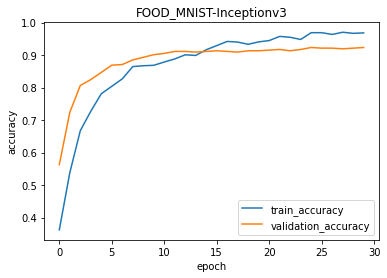

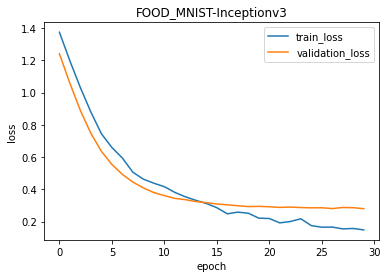

In [64]:
plot_accuracy(history,'FOOD_MNIST-Inceptionv3')
plot_loss(history,'FOOD_MNIST-Inceptionv3')

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
!wget -O babybackribs.jpg https://cook.fnr.sndimg.com/content/dam/images/cook/fullset/2012/5/11/0/0041270F1_Baby-Back-Ribs_s4x3.jpg.rend.hgtvcom.826.620.suffix/1369245981352.jpg
!wget -O baklava.jpg https://cleobuttera.com/wp-content/uploads/2018/03/lifted-baklava-720x720.jpg
!wget -O beefcarpaccio.jpg https://www.seriouseats.com/recipes/images/2013/05/20130531-italian-easy-carpaccio.jpg

--2021-04-18 12:42:28--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 62.75.168.50
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|62.75.168.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75560 (74K) [image/jpeg]
Saving to: ‘samosa.jpg’

samosa.jpg          100%[===================>]  73.79K   284KB/s    in 0.3s    

2021-04-18 12:42:29 (284 KB/s) - ‘samosa.jpg’ saved [75560/75560]

--2021-04-18 12:42:29--  https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
Resolving acleanbake.com (acleanbake.com)... 138.197.203.41
Connecting to acleanbake.com (acleanbake.com)|138.197.203.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114276 (112K) [image/jpeg]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[===================>] 111.60K  --.-KB/s    in 0.1s

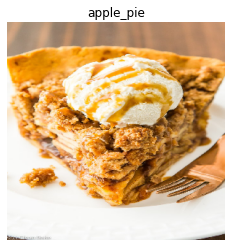

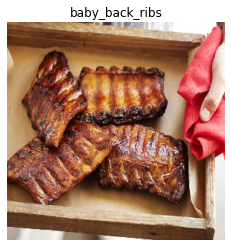

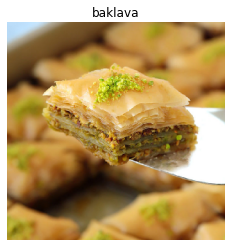

In [ ]:
images = []
images.append('applepie.jpg')
images.append('babybackribs.jpg')
images.append('baklava.jpg')
predict_class(model, images, True)
